In [ ]:
#https://facebook.github.io/prophet/
#Test on Google Colab, 20200419
#@Project: AxiomQuant Data Project Exercise
#@author: Yuan Ji
#
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels as sm
%matplotlib inline
from google.colab import files
uploaded = files.upload()
import io
data = pd.read_csv(io.BytesIO(uploaded['data.csv']))

Saving data.csv to data (1).csv


#Prophet简要介绍

Prophet 是Facebook开发的一款时间序列分析包，实际上就是statsmodel里面ARIMA/SARIMA模型的更加稳健的实现。statsmodel里的ARIMA模型往往需要对AR(p)和MA(q)的阶数根据ACF和PACF的截尾拖尾进行调参，prophet要做的更好。

优点：便捷快速，对缺失值(NA)的处理；很好的异常值处理。而且可以较好的反应节假日效应(holiday effect), 各种尺度的周期性(Seasonal:year, month, weekdays, day),以及更好的异常值处理

缺点： 优点的反面就是缺点。由于超参数调节已经被隐藏，所以不能对模型就行底层的理解和修改。

#原理

包含了趋势项g，季节项s，节假日h，以及误差项$\epsilon$

 $ y(t)=g(t)+s(t)+h(t)+\epsilon_{(t)} $

 详情可见Facebook的论文:https://peerj.com/preprints/3190v2/

##趋势项
 趋势项有两个重要的函数，一个是基于逻辑回归函数(logistic)的（非线性增长），另一个是基于分段线性(linear)函数的（线性增长）。分段线性实际上就是statsmodel里的AR模型的扩展。

而逻辑回归部分用于处理时间序列的趋势变化，在现实的时间序列中，曲线的走势肯定不会一直保持不变，在某些特定的时候或者有着某种潜在的周期曲线会发生变化，模型定义了增长率k发生变化时对应的点，将其称作changepoints。

在Prophet 里面，是需要设置变点的位置的，而每一段的趋势和走势也是会根据变点的情况而改变的。在程序里面有两种方法，一种是通过人工指定的方式指定变点的位置；另外一种是通过算法来自动选择。在默认的函数里面，Prophet 会选择 n_changepoints = 25 个变点，然后设置变点的范围是前 80%，也就是在时间序列的前 80% 的区间内会设置变点。之后还要看一些边界条件是否合理，例如时间序列的点数是否少于 n_changepoints 等内容；其次如果边界条件符合，那变点的位置就是均匀分布的。

##季节项
季节项本质上就是依据时间进行了傅里叶分解，提取主要频率。

##节日项
在现实环境中，节假日或者是一些大事件都会对时间序列造成很大影响，而且这些时间点往往不存在周期性,对这些点的分析是必要的.

节假日模型将不同节假日在不同时间点下的影响视作独立的模型，并且可以为不同的节假日设置不同的前后窗口值，表示该节假日会影响前后一段时间的时间序列.






In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 112440 entries, 2020-01-02 09:31:00 to 2020-07-01 10:00:00
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Date       112440 non-null  int64         
 1   Time       112440 non-null  object        
 2   Id         112440 non-null  int64         
 3   NumTrades  112440 non-null  int64         
 4   ds         112440 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 5.1+ MB


In [ ]:
# Avoids scroll-in-the-scroll in the entire Notebook
from IPython.display import Javascript

<IPython.core.display.Javascript object>

#总结

在该notebook中, 我主要探讨了不同时间颗粒度和训练数据量对Prophet预测的影响。

对于日内预测，即对2020-07-01 10:00以后数据的预测， 两天的训练数据给出的预测可能更好的反应了日内的变化。如果只选择前30min的数据，prophet只能给出线性的预测。

对于五日预测， 以天为粒度较稳定给出均值的预测；而以小时和分钟为粒度的预测更丰富的描述了日内波动，但可靠性有待检查。

#Part-1: 基于2020-01-02:2020-06-30所有数据给出下五个交易日的预测

依据半年数据做五日预测：

Prediction by day: 相较于hour,minute,比较平稳，描述了均值

Prediction by hour/minute: 波动比较大， 分钟预测波动较大

In [ ]:
data['ds'] = pd.to_datetime(data['Date'].astype(str)+' '+data['Time'],format="%Y%m%d %H:%M:%S")
data.index = data['ds']

stock_1 = data[data["Id"] == 1]
stock_2 = data[data["Id"] == 2]
stock_3 = data[data["Id"] == 3]
stock_4 = data[data["Id"] == 4]
stock_1.head(10)

,Date,Time,Id,NumTrades,ds
ds,,,,,
2020-01-02 09:31:00,20200102,09:31:00.000,1,310,2020-01-02 09:31:00
2020-01-02 09:32:00,20200102,09:32:00.000,1,232,2020-01-02 09:32:00
2020-01-02 09:33:00,20200102,09:33:00.000,1,152,2020-01-02 09:33:00
2020-01-02 09:34:00,20200102,09:34:00.000,1,172,2020-01-02 09:34:00
2020-01-02 09:35:00,20200102,09:35:00.000,1,111,2020-01-02 09:35:00
2020-01-02 09:36:00,20200102,09:36:00.000,1,99,2020-01-02 09:36:00
2020-01-02 09:37:00,20200102,09:37:00.000,1,89,2020-01-02 09:37:00
2020-01-02 09:38:00,20200102,09:38:00.000,1,122,2020-01-02 09:38:00
2020-01-02 09:39:00,20200102,09:39:00.000,1,154,2020-01-02 09:39:00


In [ ]:
stock_1_prophet = pd.DataFrame()
stock_1_prophet['ds'] = stock_1.index
stock_1_prophet['y'] = stock_1["NumTrades"].values

stock_2_prophet = pd.DataFrame()
stock_2_prophet['ds'] = stock_2.index
stock_2_prophet['y'] = stock_2["NumTrades"].values

stock_3_prophet = pd.DataFrame()
stock_3_prophet['ds'] = stock_3.index
stock_3_prophet['y'] = stock_3["NumTrades"].values

stock_4_prophet = pd.DataFrame()
stock_4_prophet['ds'] = stock_4.index
stock_4_prophet['y'] = stock_4["NumTrades"].values

In [ ]:
from fbprophet.plot import plot
def prophet_daily(model, periods = 10):
    #预测10天
    future = model.make_future_dataframe(periods = periods, freq='D')

    #only trading hours are allowed
    #It is necessary since large variance will show up in forecast if no processing is introduced
    future2 = future.copy()
    future2 = future2[future2['ds'].dt.dayofweek < 5]
    future2 = future2[(future2['ds'].dt.hour >= 9) & (future2['ds'].dt.hour <= 15)]
    future2 = future2[(future2['ds'].dt.hour <= 11) | (future2['ds'].dt.hour >= 13)]

    #print(future2.head(10))

    forecast = model.predict(future2)
    fig = plot(model, forecast, figsize=(10, 6), xlabel='Date', ylabel='NumTrades')
    ax = fig.gca()
    ax.set_title("Daily forecast", size=34)
    #ax.set_xlabel("X", size=34)
    #ax.set_ylabel("Y", size=34)
    #ax.tick_params(axis="x", labelsize=24)
    #ax.tick_params(axis="y", labelsize=24)

    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)


In [ ]:
def prophet_hour(model, periods = 240):
    #predict for each trading hour
    #预测10天, 240h
    future = model.make_future_dataframe(periods = periods, freq='H')

    #only trading hours are allowed
    future2 = future.copy()
    future2 = future2[future2['ds'].dt.dayofweek < 5]
    future2 = future2[(future2['ds'].dt.hour >= 9) & (future2['ds'].dt.hour <= 15)]
    future2 = future2[(future2['ds'].dt.hour <= 11) | (future2['ds'].dt.hour >= 13)]

    #print(future2.head(10))

    forecast = model.predict(future2)
    fig = plot(model, forecast, figsize=(10, 6), xlabel='Date', ylabel='NumTrades')
    ax = fig.gca()
    ax.set_title("Hourly forecast", size=34)

    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

In [ ]:
def prophet_minute(model, periods = 14400):
    #predict for each trading minute
    #预测10天, 240*60 = 14400 minutes
    future = model.make_future_dataframe(periods = periods, freq='1min')

    #only trading hours are allowed
    future2 = future.copy()
    future2 = future2[future2['ds'].dt.dayofweek < 5]
    future2 = future2[(future2['ds'].dt.hour > 9) & (future2['ds'].dt.hour <= 15)]
    future2 = future2[(future2['ds'].dt.hour <= 11.5) | (future2['ds'].dt.hour >= 13)]

    #print(future2.tail(10))

    forecast = model.predict(future2)

    fig = plot(model, forecast, figsize=(10, 6), xlabel='Date', ylabel='NumTrades')
    ax = fig.gca()
    ax.set_title("Minute forecast", size=34)
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

In [ ]:
def predict(stock_prophet, days = 10):
    #默认预测10天
    model = Prophet()
    model.fit(stock_prophet)
    #print("Prediction by day")
    prophet_daily(model, periods = days)
    #print("Prediction by hour")
    prophet_hour(model, periods = days*24)
    #print("Prediction by minute")
    prophet_minute(model, periods = days*24*60)

尝试用不同精度预测未来五天的交易量：每天，每小时，每分钟

Daily forecast: 比较平稳的预测了每天均值

Hourly forecast: 描述了一些日内变化的趋势:比如open,close时会有峰值-->这带来了高频的信号

Minute forecast: 变化幅度较大,不平稳

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


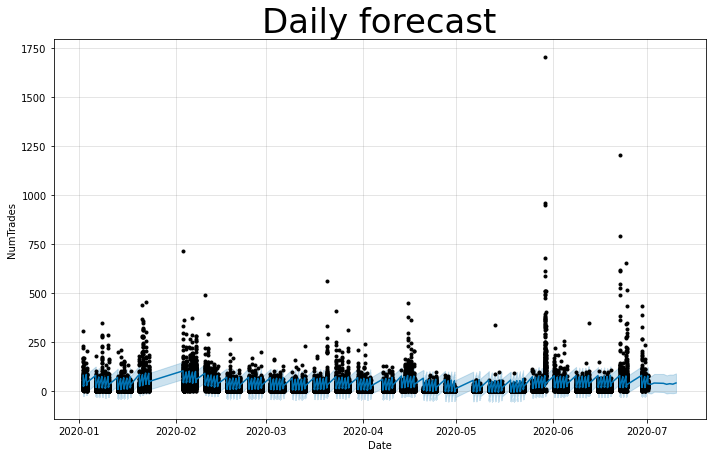

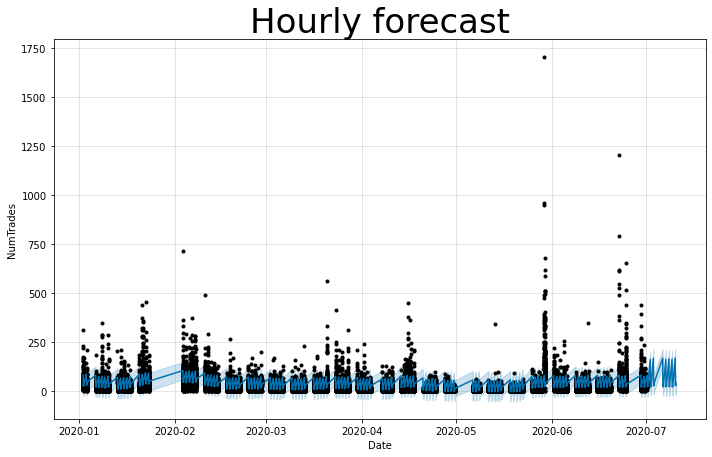

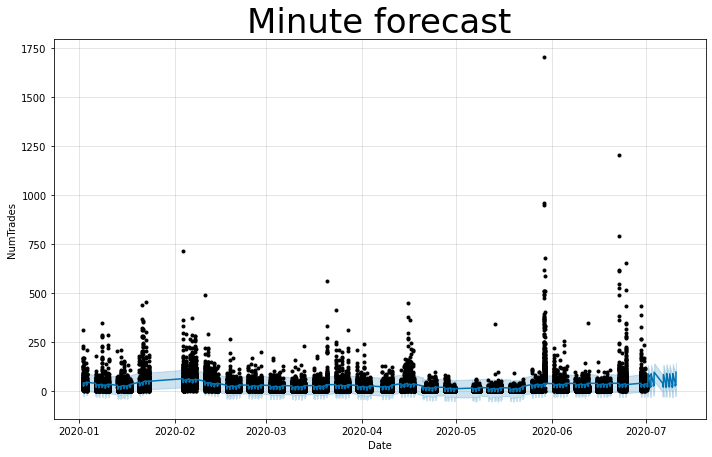

In [ ]:
#stock_1
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})''')) #fullsize display
predict(stock_1_prophet)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


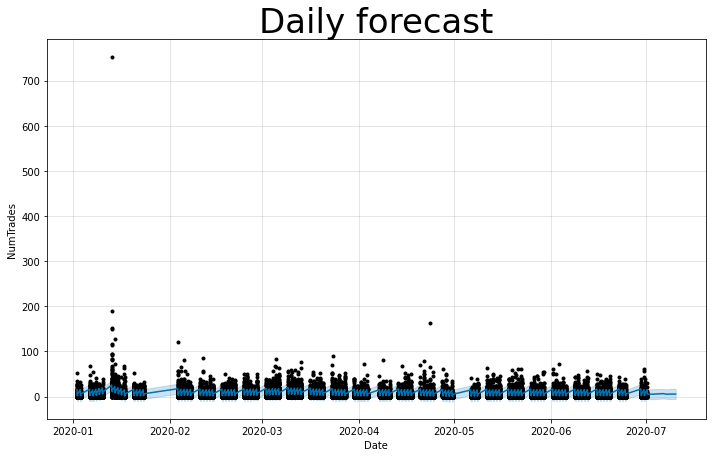

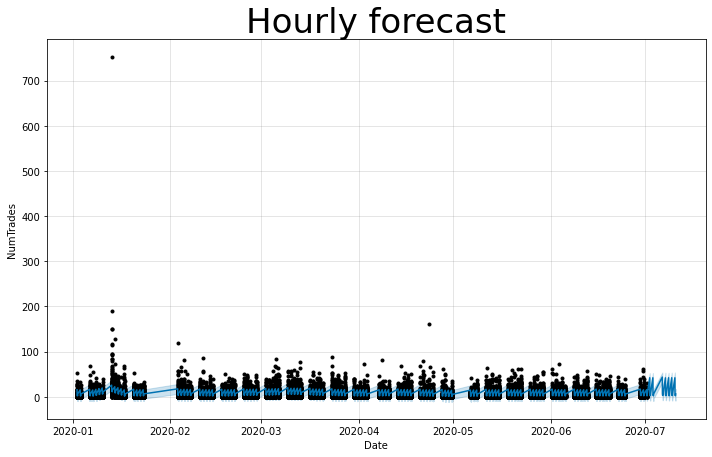

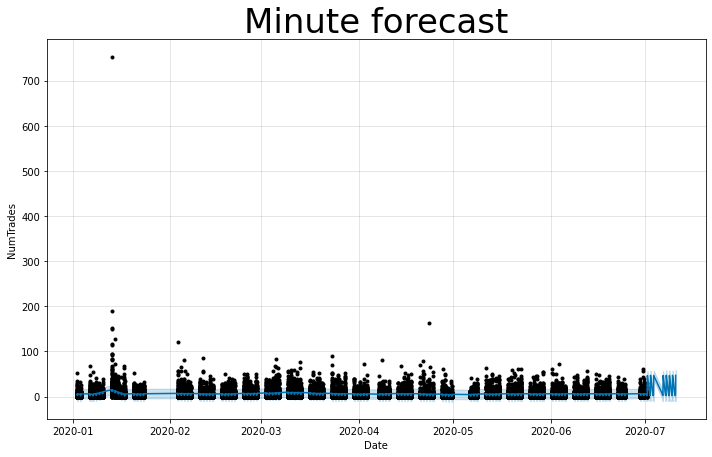

In [ ]:
#stock_2
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})''')) #fullsize display
predict(stock_2_prophet)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


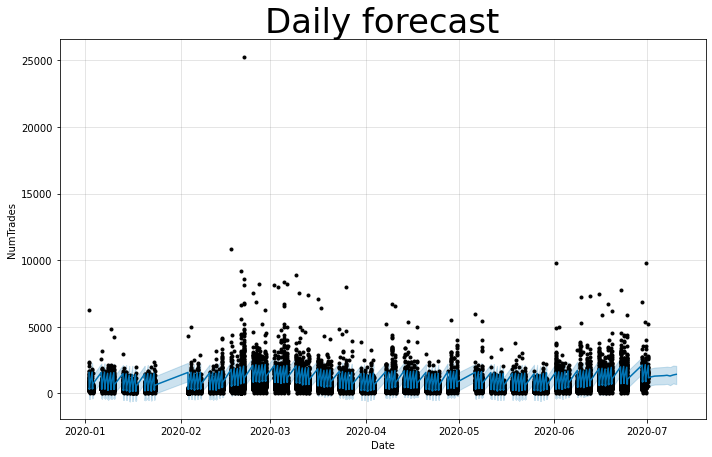

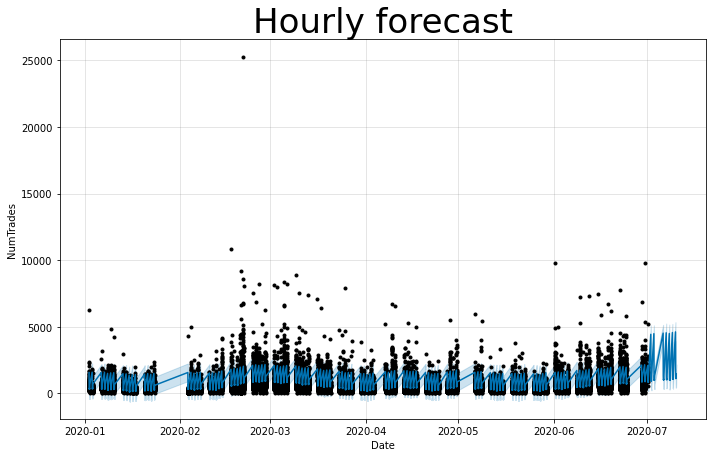

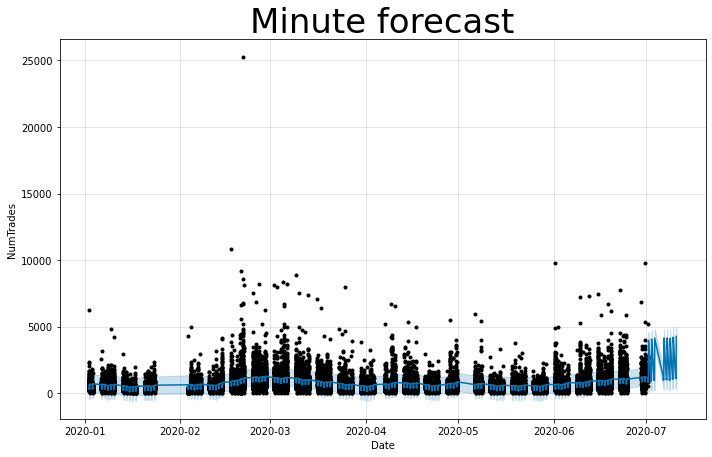

In [ ]:
#stock_3
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})''')) #fullsize display
predict(stock_3_prophet)

可以看到stock-4在五月后的风格改变(由平稳改为大涨)被Prophet的change_point特性捕捉到了



<IPython.core.display.Javascript object>

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


<IPython.core.display.Javascript object>

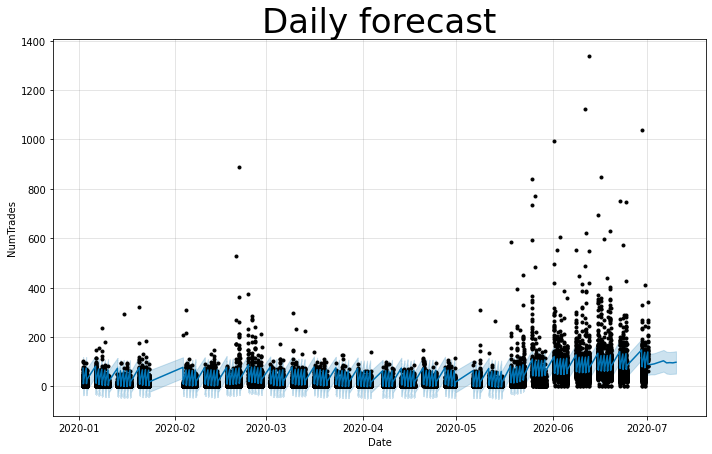

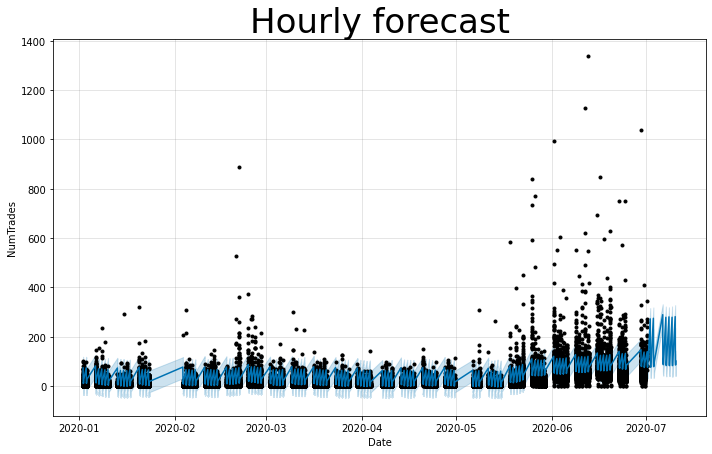

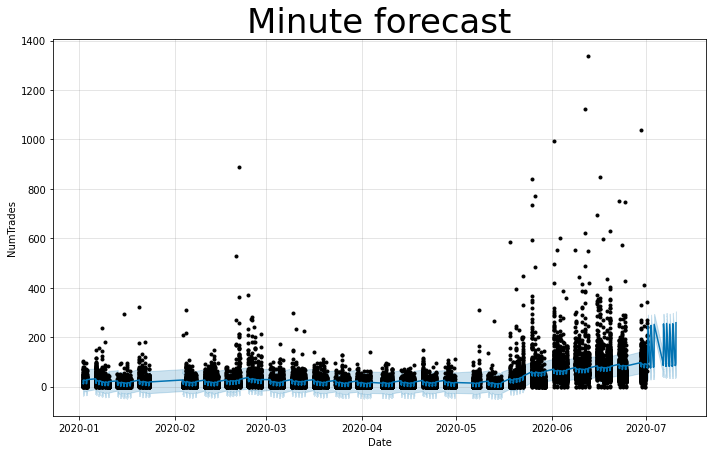

In [ ]:
#stock_4
predict(stock_4_prophet)
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})''')) #fullsize display


#Part-2: 基于2020-06-15:2020-06-30 半个月的数据给出下五个交易日的预测

依据半个月数据做五日预测：

Prediction by day: 相较于hour,minute,比较平稳

Prediction by hour/minute: 波动比较大， 分钟预测波动较大

In [ ]:
#prediction based on data on 2020-06
stock_1 = data[data["Id"] == 1]["2020-06-15":]
stock_2 = data[data["Id"] == 2]["2020-06-15":]
stock_3 = data[data["Id"] == 3]["2020-06-15":]
stock_4 = data[data["Id"] == 4]["2020-06-15":]

stock_1_June = pd.DataFrame()
stock_1_June['ds'] = stock_1.index
stock_1_June['y'] = stock_1["NumTrades"].values

stock_2_June = pd.DataFrame()
stock_2_June['ds'] = stock_2.index
stock_2_June['y'] = stock_2["NumTrades"].values

stock_3_June = pd.DataFrame()
stock_3_June['ds'] = stock_3.index
stock_3_June['y'] = stock_3["NumTrades"].values

stock_4_June = pd.DataFrame()
stock_4_June['ds'] = stock_4.index
stock_4_June['y'] = stock_4["NumTrades"].values

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


<IPython.core.display.Javascript object>

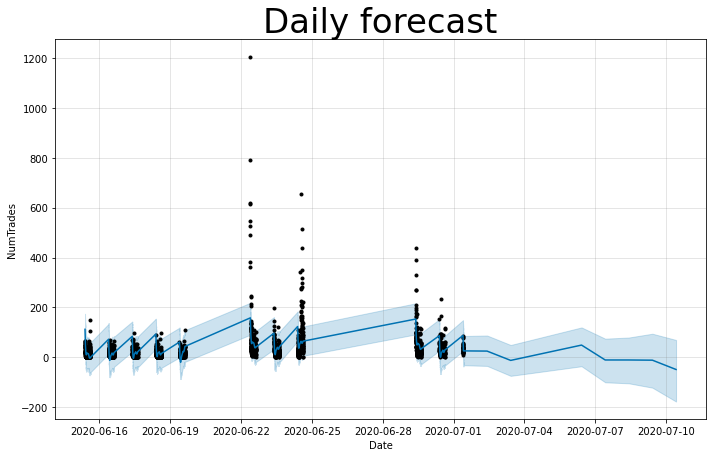

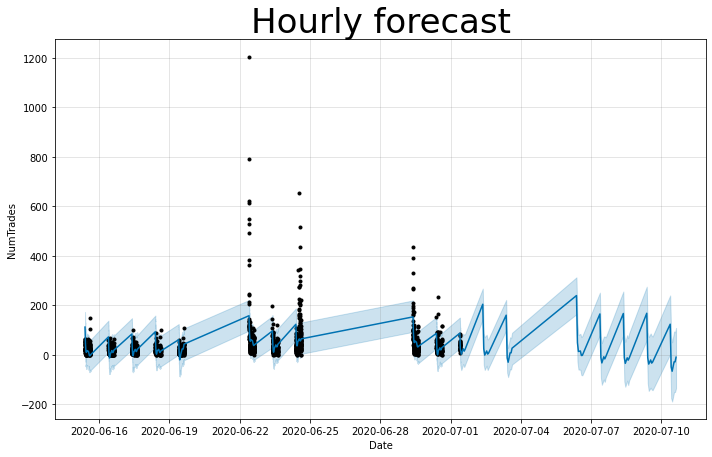

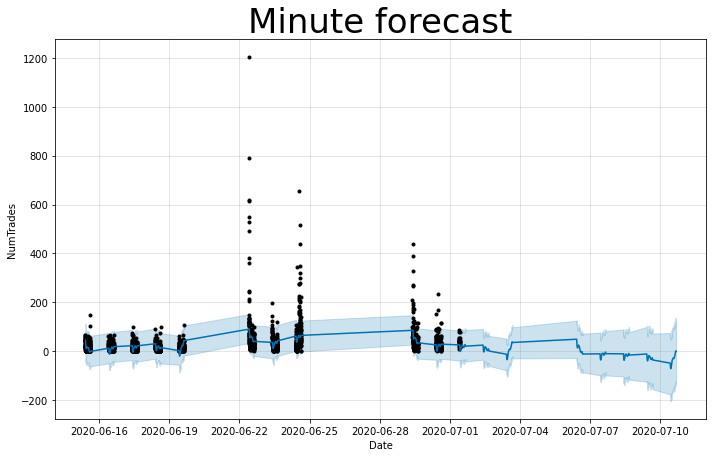

In [ ]:
predict(stock_1_June)
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})''')) #fullsize display

<IPython.core.display.Javascript object>

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


<IPython.core.display.Javascript object>

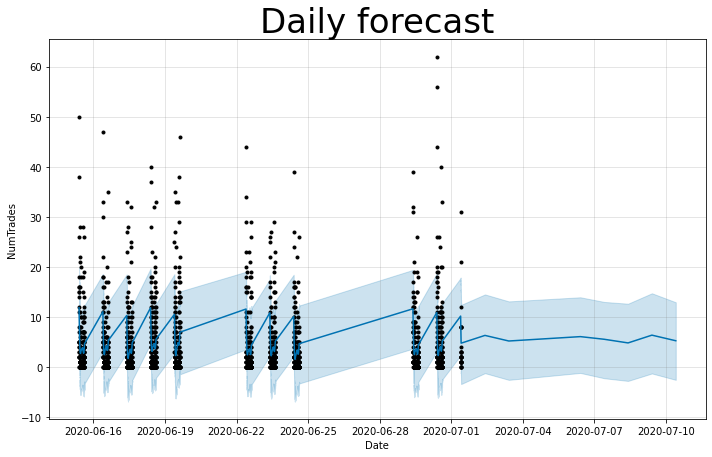

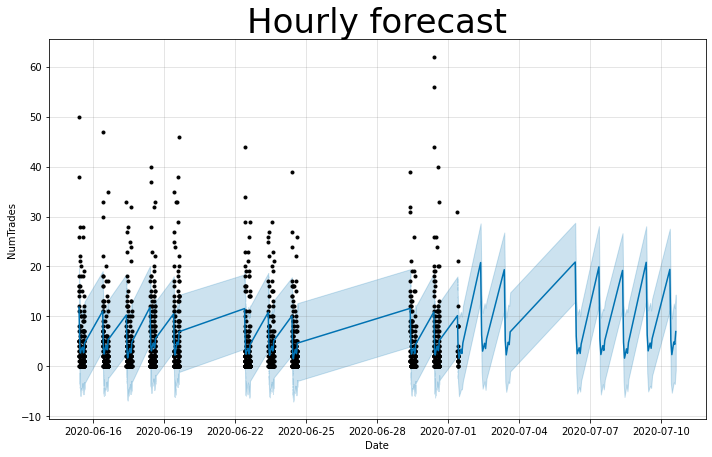

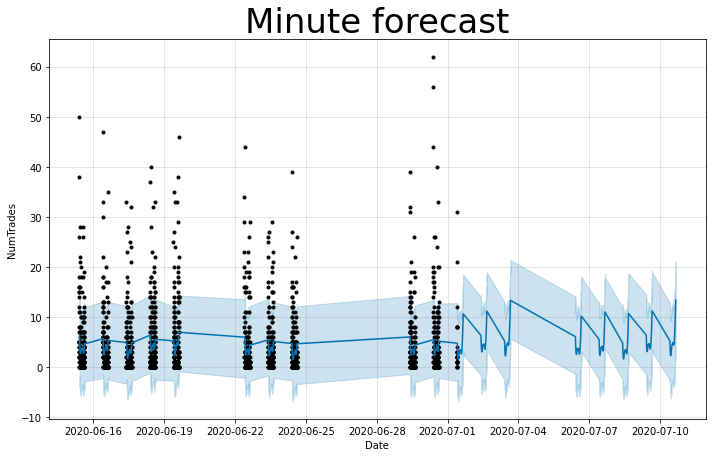

In [ ]:
predict(stock_2_June)
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})''')) #fullsize display

<IPython.core.display.Javascript object>

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


<IPython.core.display.Javascript object>

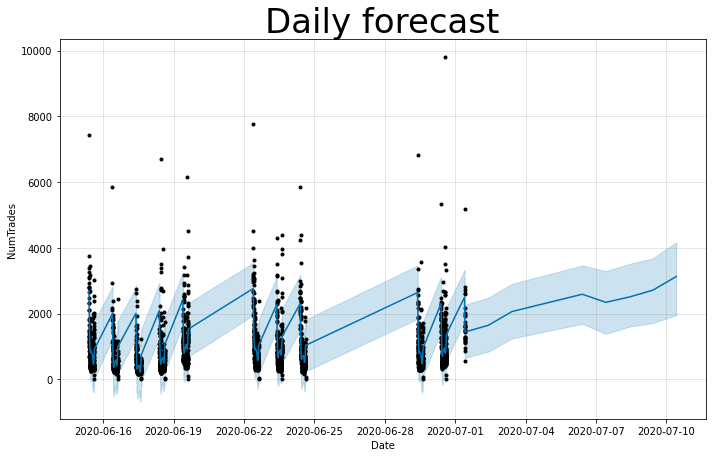

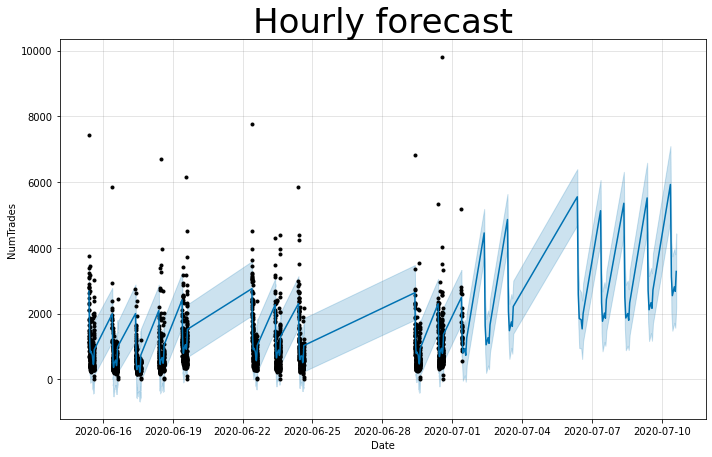

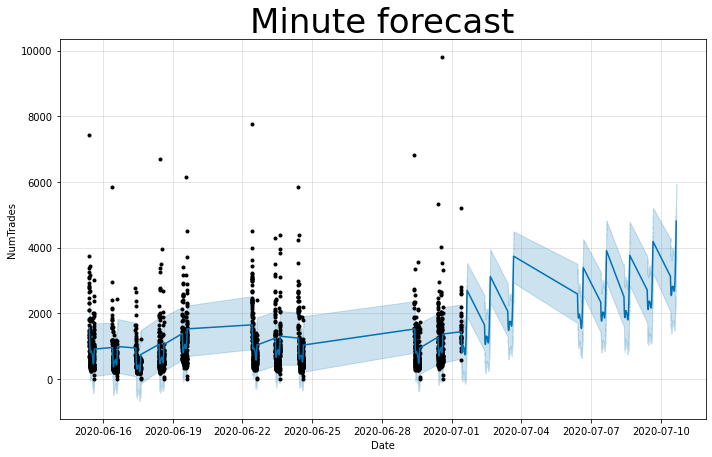

In [ ]:
predict(stock_3_June)
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})''')) #fullsize display

<IPython.core.display.Javascript object>

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


<IPython.core.display.Javascript object>

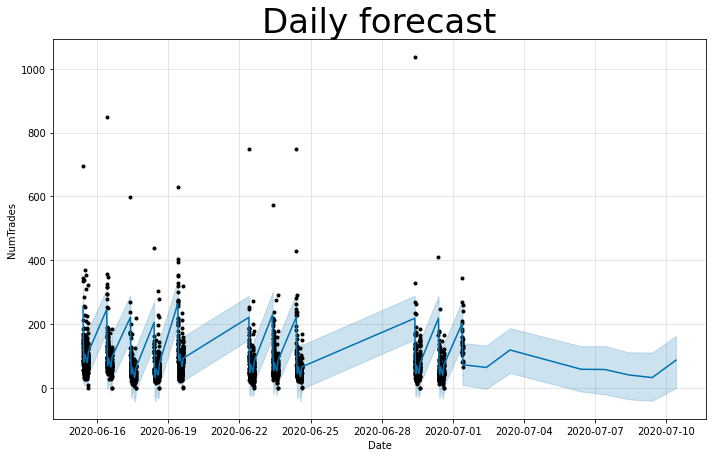

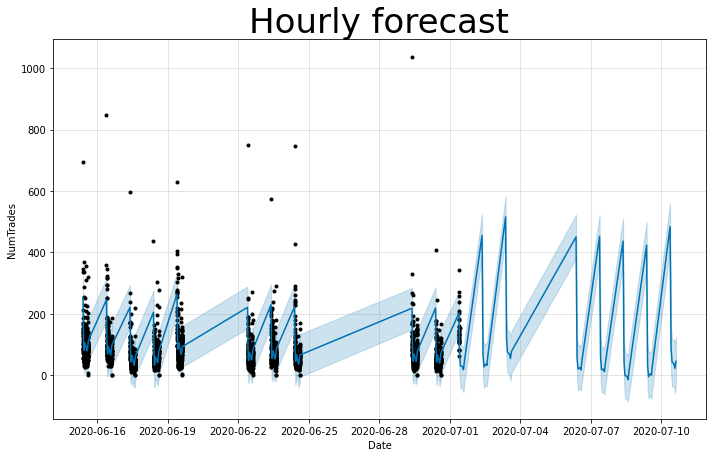

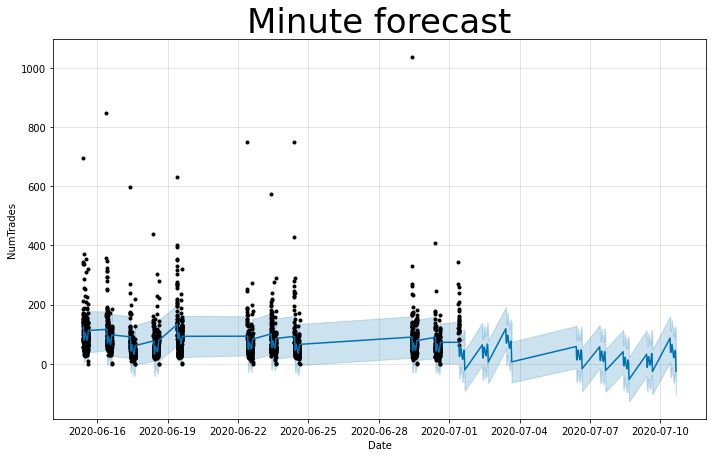

In [ ]:
predict(stock_4_June)
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})''')) #fullsize display

#Part-3: 基于2020-07-01的前三十分钟交易量给出本日10:00之后的预测

由于开始30min的数据没有经历完整的交易日，失去了daily seasonality，所以Prophet模型无法识别11:30-13:00是休市的

但总体上，Prophet给出了线性的预测，这和线性自回归模型(AR)是一致的。

由于数据较少，这样的线性预测一定是不准确的。

In [ ]:
#prediction based on data on 20200701
stock_1 = data[data["Id"] == 1]["2020-07-01"]
stock_2 = data[data["Id"] == 2]["2020-07-01"]
stock_3 = data[data["Id"] == 3]["2020-07-01"]
stock_4 = data[data["Id"] == 4]["2020-07-01"]

stock_1_oneday = pd.DataFrame()
stock_1_oneday['ds'] = stock_1.index
stock_1_oneday['y'] = stock_1["NumTrades"].values

stock_2_oneday = pd.DataFrame()
stock_2_oneday['ds'] = stock_2.index
stock_2_oneday['y'] = stock_2["NumTrades"].values

stock_3_oneday = pd.DataFrame()
stock_3_oneday['ds'] = stock_3.index
stock_3_oneday['y'] = stock_3["NumTrades"].values

stock_4_oneday = pd.DataFrame()
stock_4_oneday['ds'] = stock_4.index
stock_4_oneday['y'] = stock_4["NumTrades"].values

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.


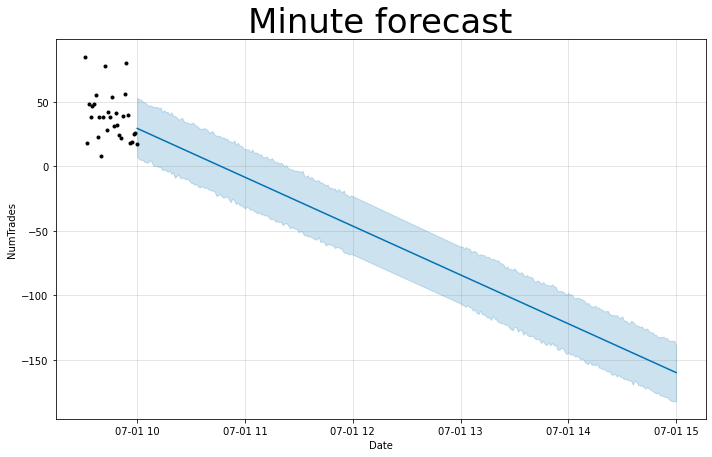

In [ ]:
#stock_1
model = Prophet()
model.fit(stock_1_oneday)
prophet_minute(model, periods=300)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.


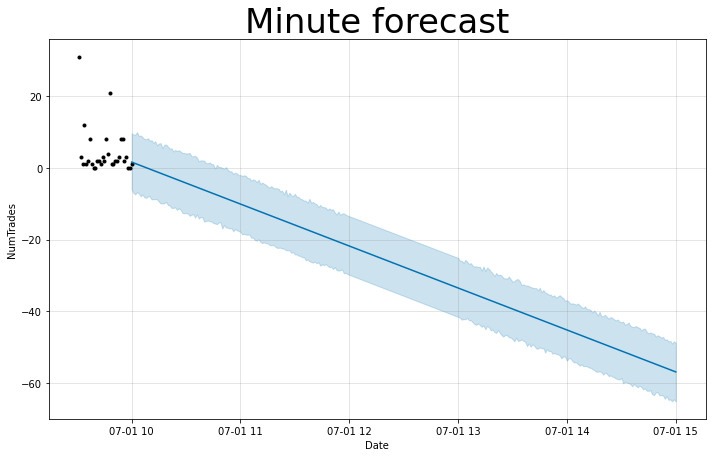

In [ ]:
#stock_2
model = Prophet()
model.fit(stock_2_oneday)
prophet_minute(model, periods=300)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.


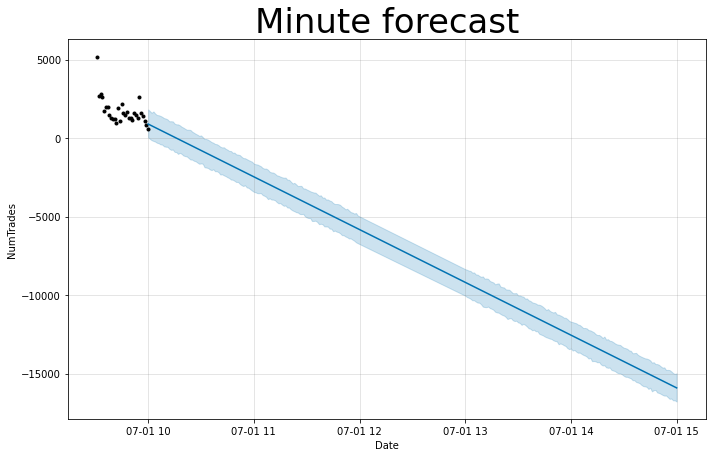

In [ ]:
#stock_3
model = Prophet()
model.fit(stock_3_oneday)
prophet_minute(model, periods=300)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.


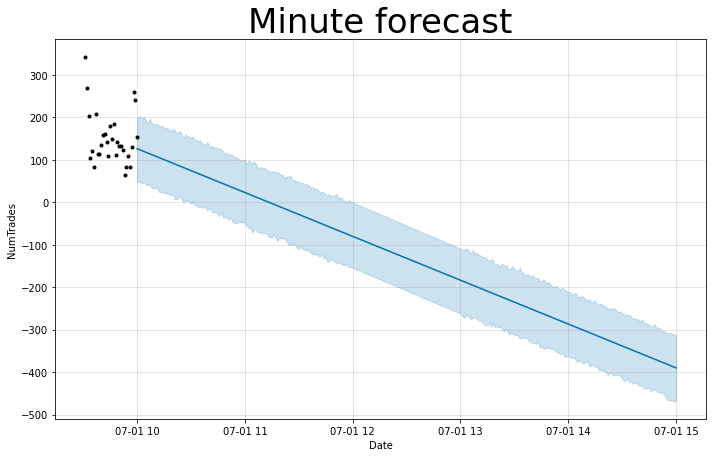

In [ ]:
#stock_4
model = Prophet()
model.fit(stock_4_oneday)
prophet_minute(model, periods=300)

#Part-4: 基于2020-06-29,06-30,07-01的数据, 预测2020-07-01 10:00之后交易量

与只采用2020-07-01的预测对比，增加两天的训练数据后，

daily seasonality 和日内的变化细节有了较好的预测（并不是线性的）

尤其是比较好的捕捉到了open和close时的峰值

并且分钟级别的预测并未出现大幅度波动，比较稳定

In [ ]:
#prediction based on data on 2020-06
stock_1 = data[data["Id"] == 1]["2020-06-29":]
stock_2 = data[data["Id"] == 2]["2020-06-29":]
stock_3 = data[data["Id"] == 3]["2020-06-29":]
stock_4 = data[data["Id"] == 4]["2020-06-29":]

stock_1_twodays = pd.DataFrame()
stock_1_twodays['ds'] = stock_1.index
stock_1_twodays['y'] = stock_1["NumTrades"].values

stock_2_twodays = pd.DataFrame()
stock_2_twodays['ds'] = stock_2.index
stock_2_twodays['y'] = stock_2["NumTrades"].values

stock_3_twodays = pd.DataFrame()
stock_3_twodays['ds'] = stock_3.index
stock_3_twodays['y'] = stock_3["NumTrades"].values

stock_4_twodays = pd.DataFrame()
stock_4_twodays['ds'] = stock_4.index
stock_4_twodays['y'] = stock_4["NumTrades"].values

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


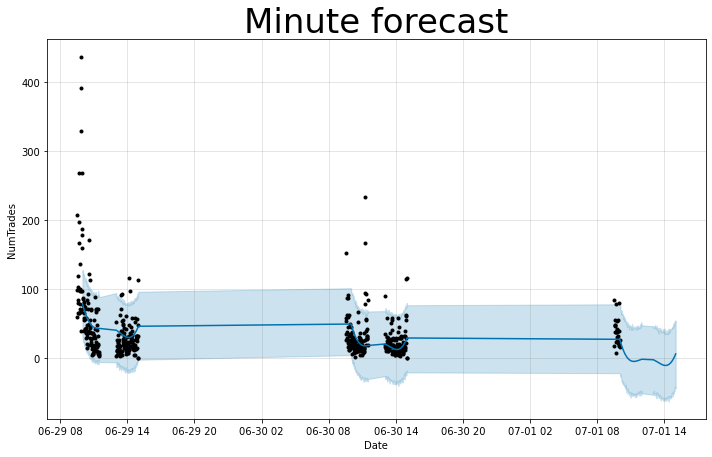

In [ ]:
#stock_1 预测07-01 10:00-15:00 300min
model = Prophet()
model.fit(stock_1_twodays)
prophet_minute(model, periods=300)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


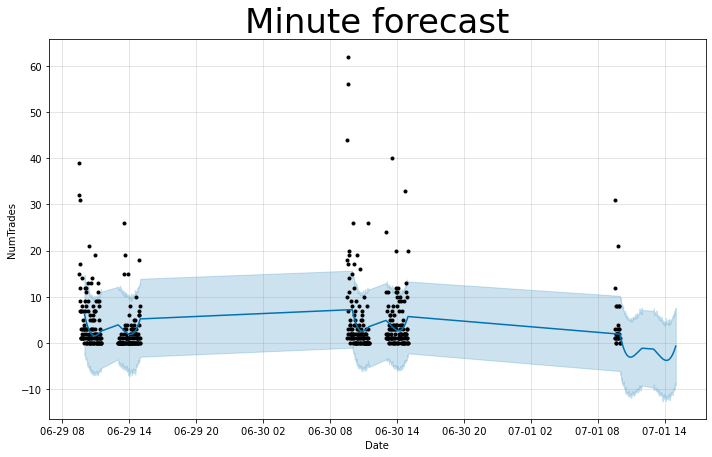

In [ ]:
#stock_2 预测07-01 10:00-15:00 300min
model = Prophet()
model.fit(stock_2_twodays)
prophet_minute(model, periods=300)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


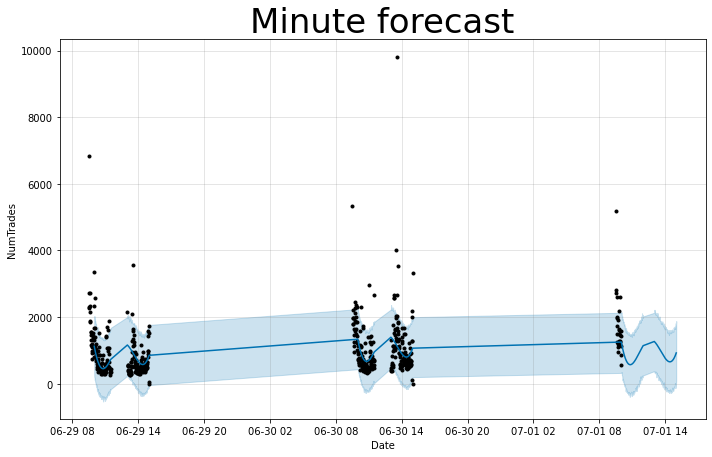

In [ ]:
#stock_3 预测07-01 10:00-15:00 300min
model = Prophet()
model.fit(stock_3_twodays)
prophet_minute(model, periods=300)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


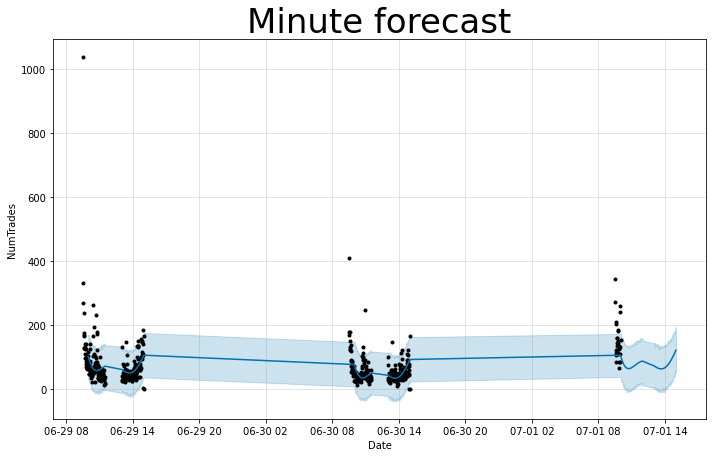

In [ ]:
#stock_4 预测07-01 10:00-15:00 300min
model = Prophet()
model.fit(stock_4_twodays)
prophet_minute(model, periods=300)